
# Seis2Rock - Synthetic Dataset <br> 
## Petrophysical Inversion on Synthetic 2D profile constructed from the Reservoir Model of the Smeaheia Field.



In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pylops
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from scipy.ndimage import gaussian_filter

from seis2rock.seis2rock_functions import *
from seis2rock.seis2rock_utils import *

from seis2rock.pem_seis2rock import pem_seis2rock

import pandas as pd

np.random.seed(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and visualizing data needed

In [22]:
f = np.load('../../data/smeaheia_synthetic.npz', 
            allow_pickle=True) 

f.files

['phi', 'vsh', 'sw', 'sw_displaced', 'depth', 'x_axis']

In [23]:
phi_2D = f['phi']
vsh_2D = f['vsh']
sw_2D = f['sw']
sw_displaced_2D = f['sw_displaced']
depth = f['depth']
x_axis = f['x_axis']

Let's see the petrophysical properties of the 2D section

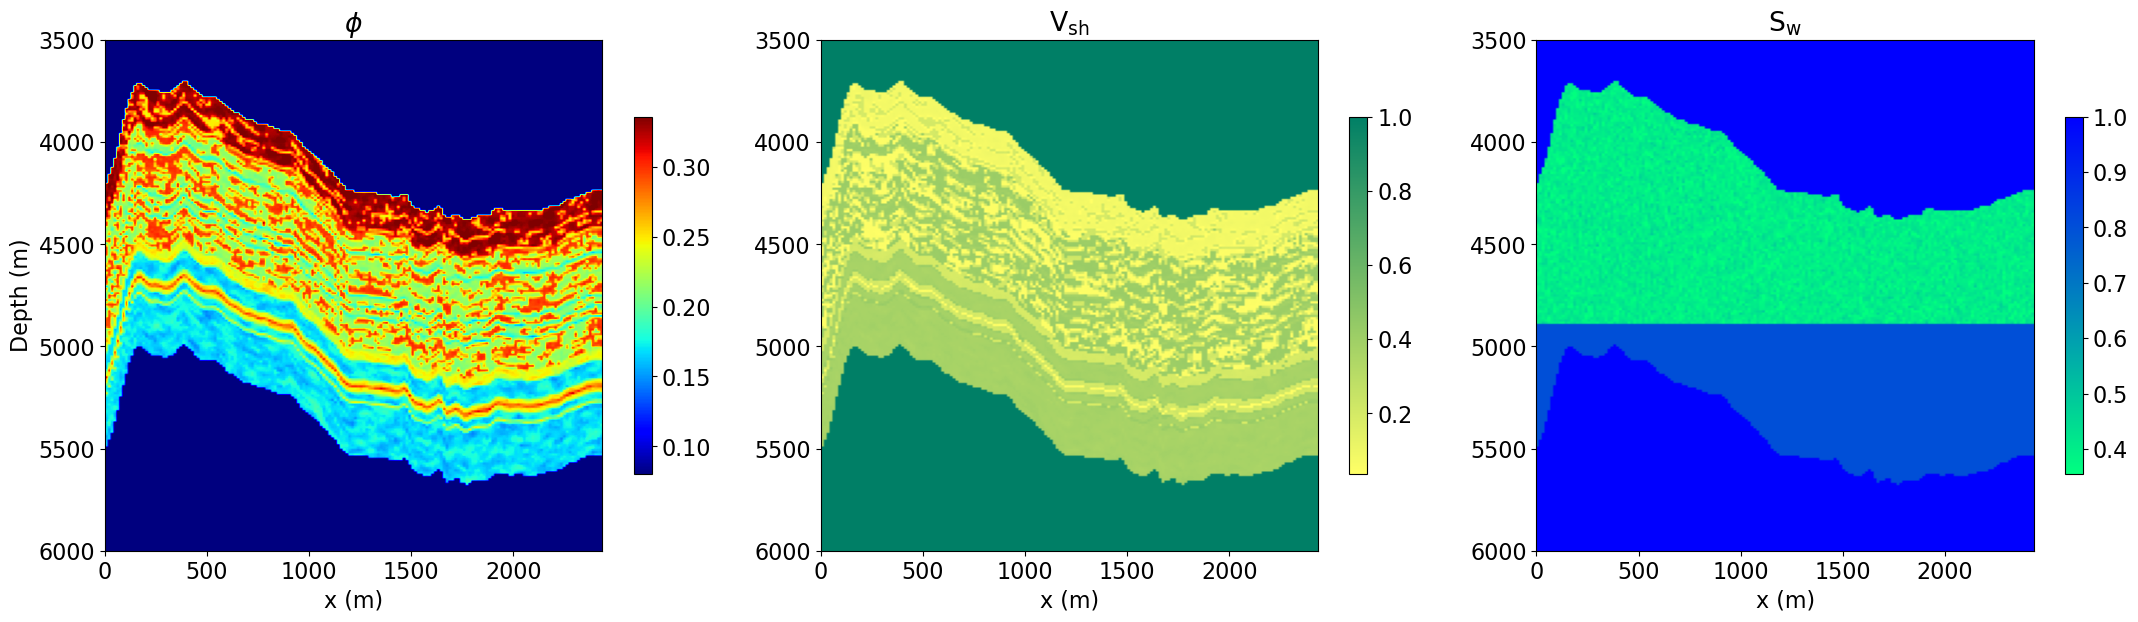

In [24]:
fig = plot_petrophysical_2D_sections(phi_2D, vsh_2D, sw_2D, x_axis, depth, fontsize=16)

Also, we need to get the background models

In [25]:
phi_2D_back, vsh_2D_back, sw_2D_back = create_background_models_synthetic(phi=phi_2D , 
                                                                          vsh=vsh_2D , 
                                                                          sw=sw_2D , 
                                                                          nsmooth=15)

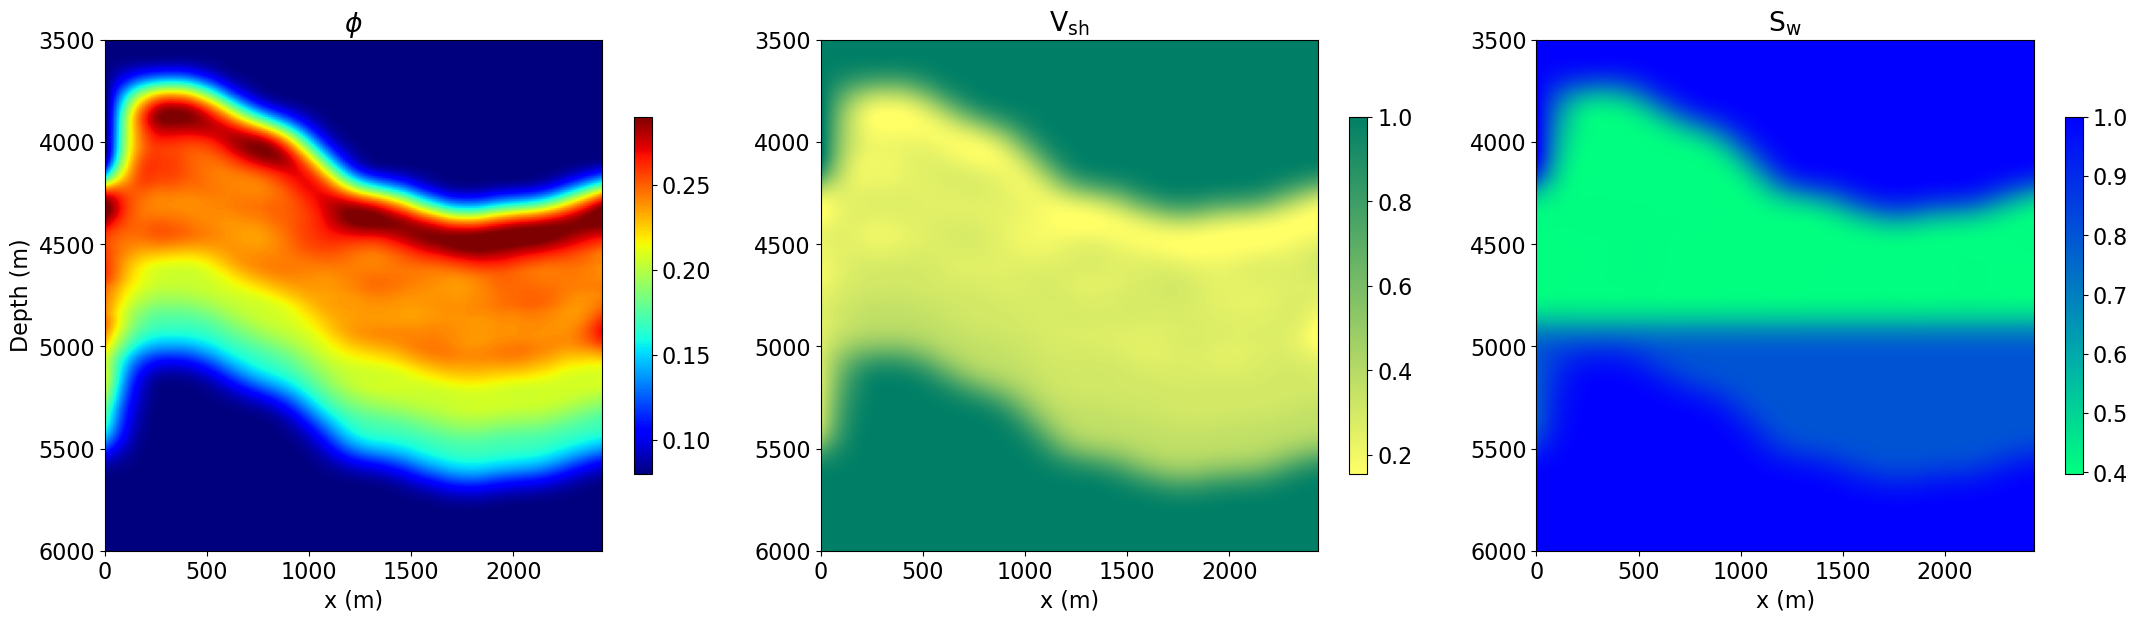

In [26]:
fig = plot_petrophysical_2D_sections(phi_2D=phi_2D_back, 
                                     vsh_2D=vsh_2D_back, 
                                     sw_2D=sw_2D_back, 
                                     x_axis=x_axis, 
                                     depth=depth, 
                                     fontsize=16)

## Rock Physics Model

Appliying Rock Physics Model for the petrophysical properties and their background models

In [27]:
vp_2D, vs_2D, rho_2D = pem_seis2rock(phi=phi_2D, vsh=vsh_2D, sw=sw_2D,
                          pres=2.41e7, temp=50, sal=10000,
                          oilgrav=20, gasgrav=0.9, gor=160)

vp_2D_back, vs_2D_back, rho_2D_back = pem_seis2rock(phi=phi_2D_back, vsh=vsh_2D_back, sw=sw_2D_back,
                          pres=2.41e7, temp=50, sal=10000,
                          oilgrav=20, gasgrav=0.9, gor=160)

Plot of the elastic properties

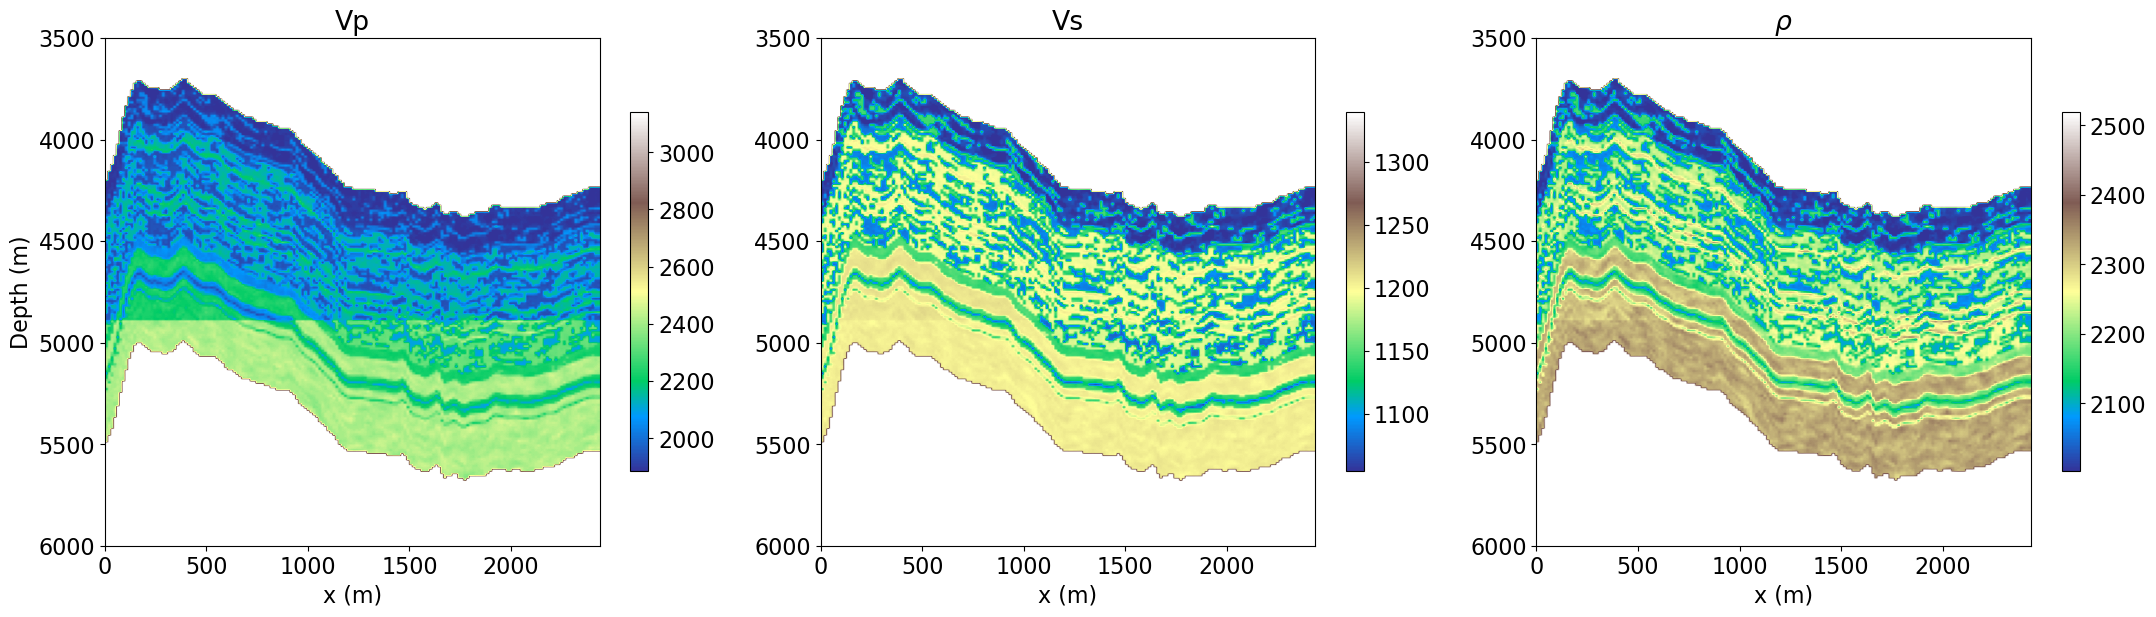

In [28]:
fig = plot_elastic_2D_sections(vp_2D=vp_2D, vs_2D=vs_2D, rho_2D=rho_2D,
                               x_axis=x_axis, depth=depth, fontsize=16)

Plot of the background elastic properties

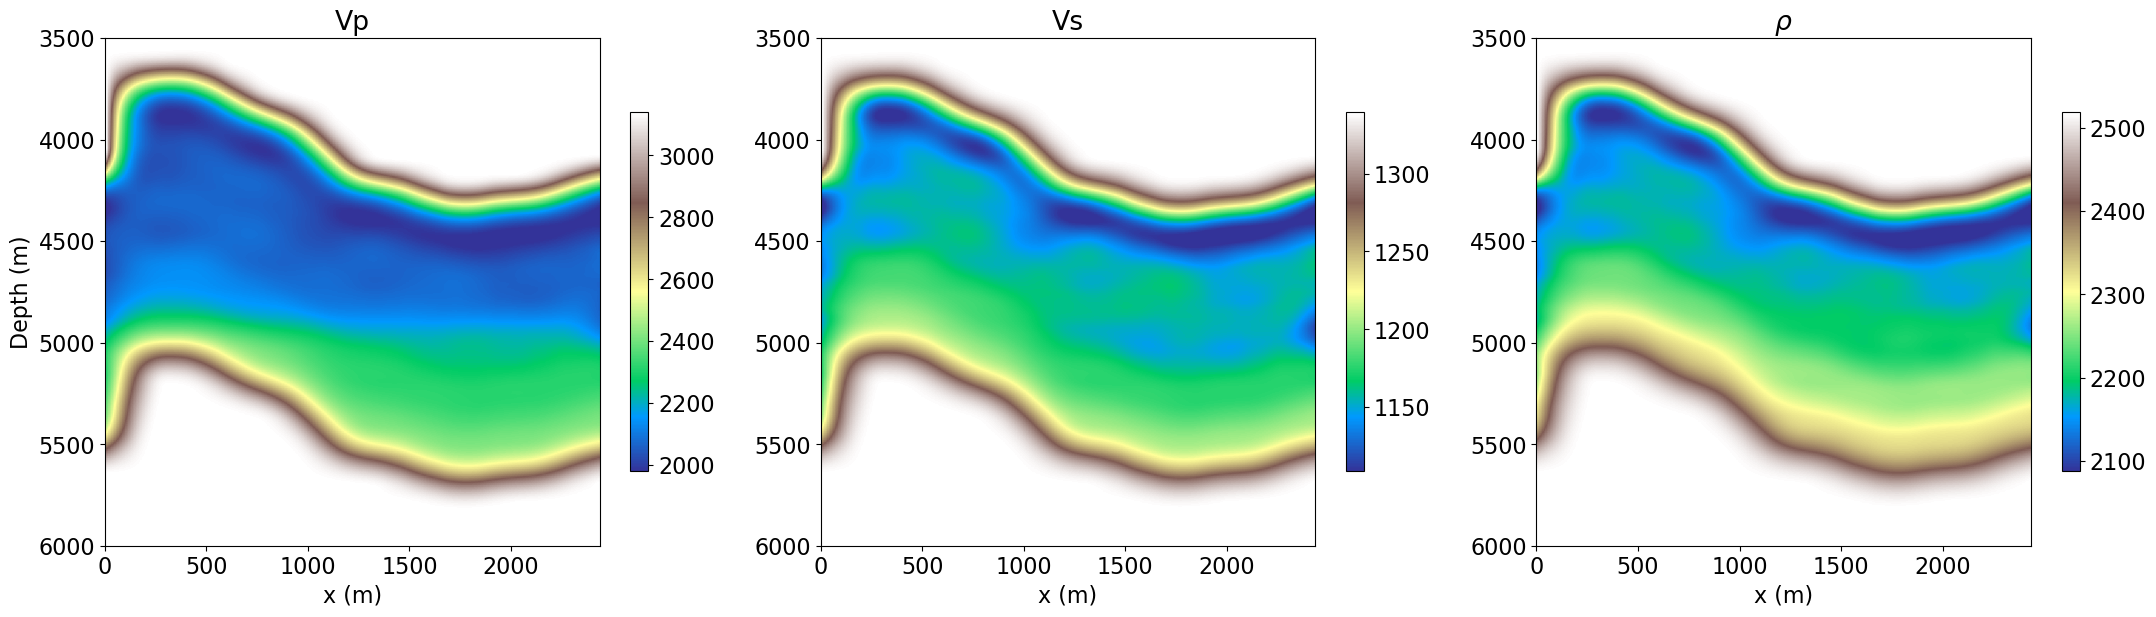

In [29]:
fig = plot_elastic_2D_sections(vp_2D=vp_2D_back, vs_2D=vs_2D_back, rho_2D=rho_2D_back,
                               x_axis=x_axis, depth=depth, fontsize=16)

### AVO synthetic gather

Here we will create the AVO gathers using the non-linear Zoeppritz equation, but first we need to create the wavelet

In [30]:
#Define the time/depth axis
ntime = depth.shape[0]
timemin, timemax = 0, depth.shape[0]**0.006
timeax = np.linspace(timemin, timemax, ntime)

# Convolve 1D
ntwav = 41
wav, th, hcenter = ricker(timeax[:ntwav//2+1], f0=20)

In [31]:
thetamin=1
thetamax=45
ntheta=45

d = avo_synthetic_gather_2D(vp=vp_2D.T, vs=vs_2D.T, rho=rho_2D.T, wav_est=wav, 
                            nt_wav=hcenter, thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

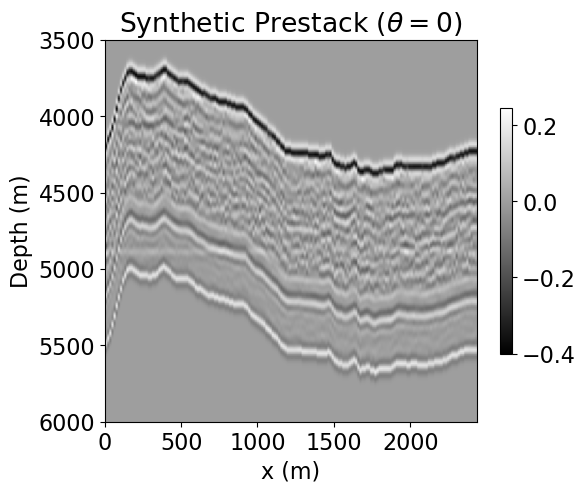

In [32]:
plt.figure(figsize=(6, 8))
plt.imshow(d[:,:,0].T, cmap='gray', extent=(x_axis[0], x_axis[-1], depth[-1], depth[0]))
plt.colorbar(shrink=0.4)
plt.title('Synthetic Prestack ($\\theta=0$)')
plt.xlabel('x (m)')
plt.ylabel('Depth (m)')
plt.show()

### Well-log information

For this notebook we will assume we have information to a well and its well log information at the profile x = 1408 m or index 100

In [33]:
## Having access to one well log
x_loc1=20
vp, vs, rho, phi, vsh, sw = extract_well_logs_from_2D(vp_2D=vp_2D, vs_2D=vs_2D, rho_2D=rho_2D,
                                                      phi_2D=phi_2D, vsh_2D=vsh_2D, sw_2D=sw_2D, 
                                                      x_loc=x_loc1)

vp_back, vs_back, rho_back, phi_back, vsh_back, sw_back = extract_well_logs_from_2D(vp_2D=vp_2D_back, vs_2D=vs_2D_back, rho_2D=rho_2D_back,
                                                      phi_2D=phi_2D_back, vsh_2D=vsh_2D_back, sw_2D=sw_2D_back, 
                                                      x_loc=x_loc1)

x_loc2=84
vp_2, vs_2, rho_2, phi_2, vsh_2, sw_2 = extract_well_logs_from_2D(vp_2D=vp_2D, vs_2D=vs_2D, rho_2D=rho_2D,
                                                      phi_2D=phi_2D, vsh_2D=vsh_2D, sw_2D=sw_2D, 
                                                      x_loc=x_loc2)

vp_2_back, vs_2_back, rho_2_back, phi_2_back, vsh_2_back, sw_2_back = extract_well_logs_from_2D(vp_2D=vp_2D_back, vs_2D=vs_2D_back, rho_2D=rho_2D_back,
                                                      phi_2D=phi_2D_back, vsh_2D=vsh_2D_back, sw_2D=sw_2D_back, 
                                                      x_loc=x_loc2)

x_loc3=140
vp_3, vs_3, rho_3, phi_3, vsh_3, sw_3 = extract_well_logs_from_2D(vp_2D=vp_2D, vs_2D=vs_2D, rho_2D=rho_2D,
                                                      phi_2D=phi_2D, vsh_2D=vsh_2D, sw_2D=sw_2D, 
                                                      x_loc=x_loc3)

vp_3_back, vs_3_back, rho_3_back, phi_3_back, vsh_3_back, sw_3_back = extract_well_logs_from_2D(vp_2D=vp_2D_back, vs_2D=vs_2D_back, rho_2D=rho_2D_back,
                                                      phi_2D=phi_2D_back, vsh_2D=vsh_2D_back, sw_2D=sw_2D_back, 
                                                      x_loc=x_loc1)


## Seis2Rock framework only 1 well

Computing AVO synthetic gathers from the well logs...
Performing SVD...
Extracting Optimal basis functions Fp..
Done! xD
Computing AVO synthetic gather for background models...
Calculating matrix of optimal coefficients Cp...
Creating the new data term (Petrophysical coefficeints B)...
Done xD !


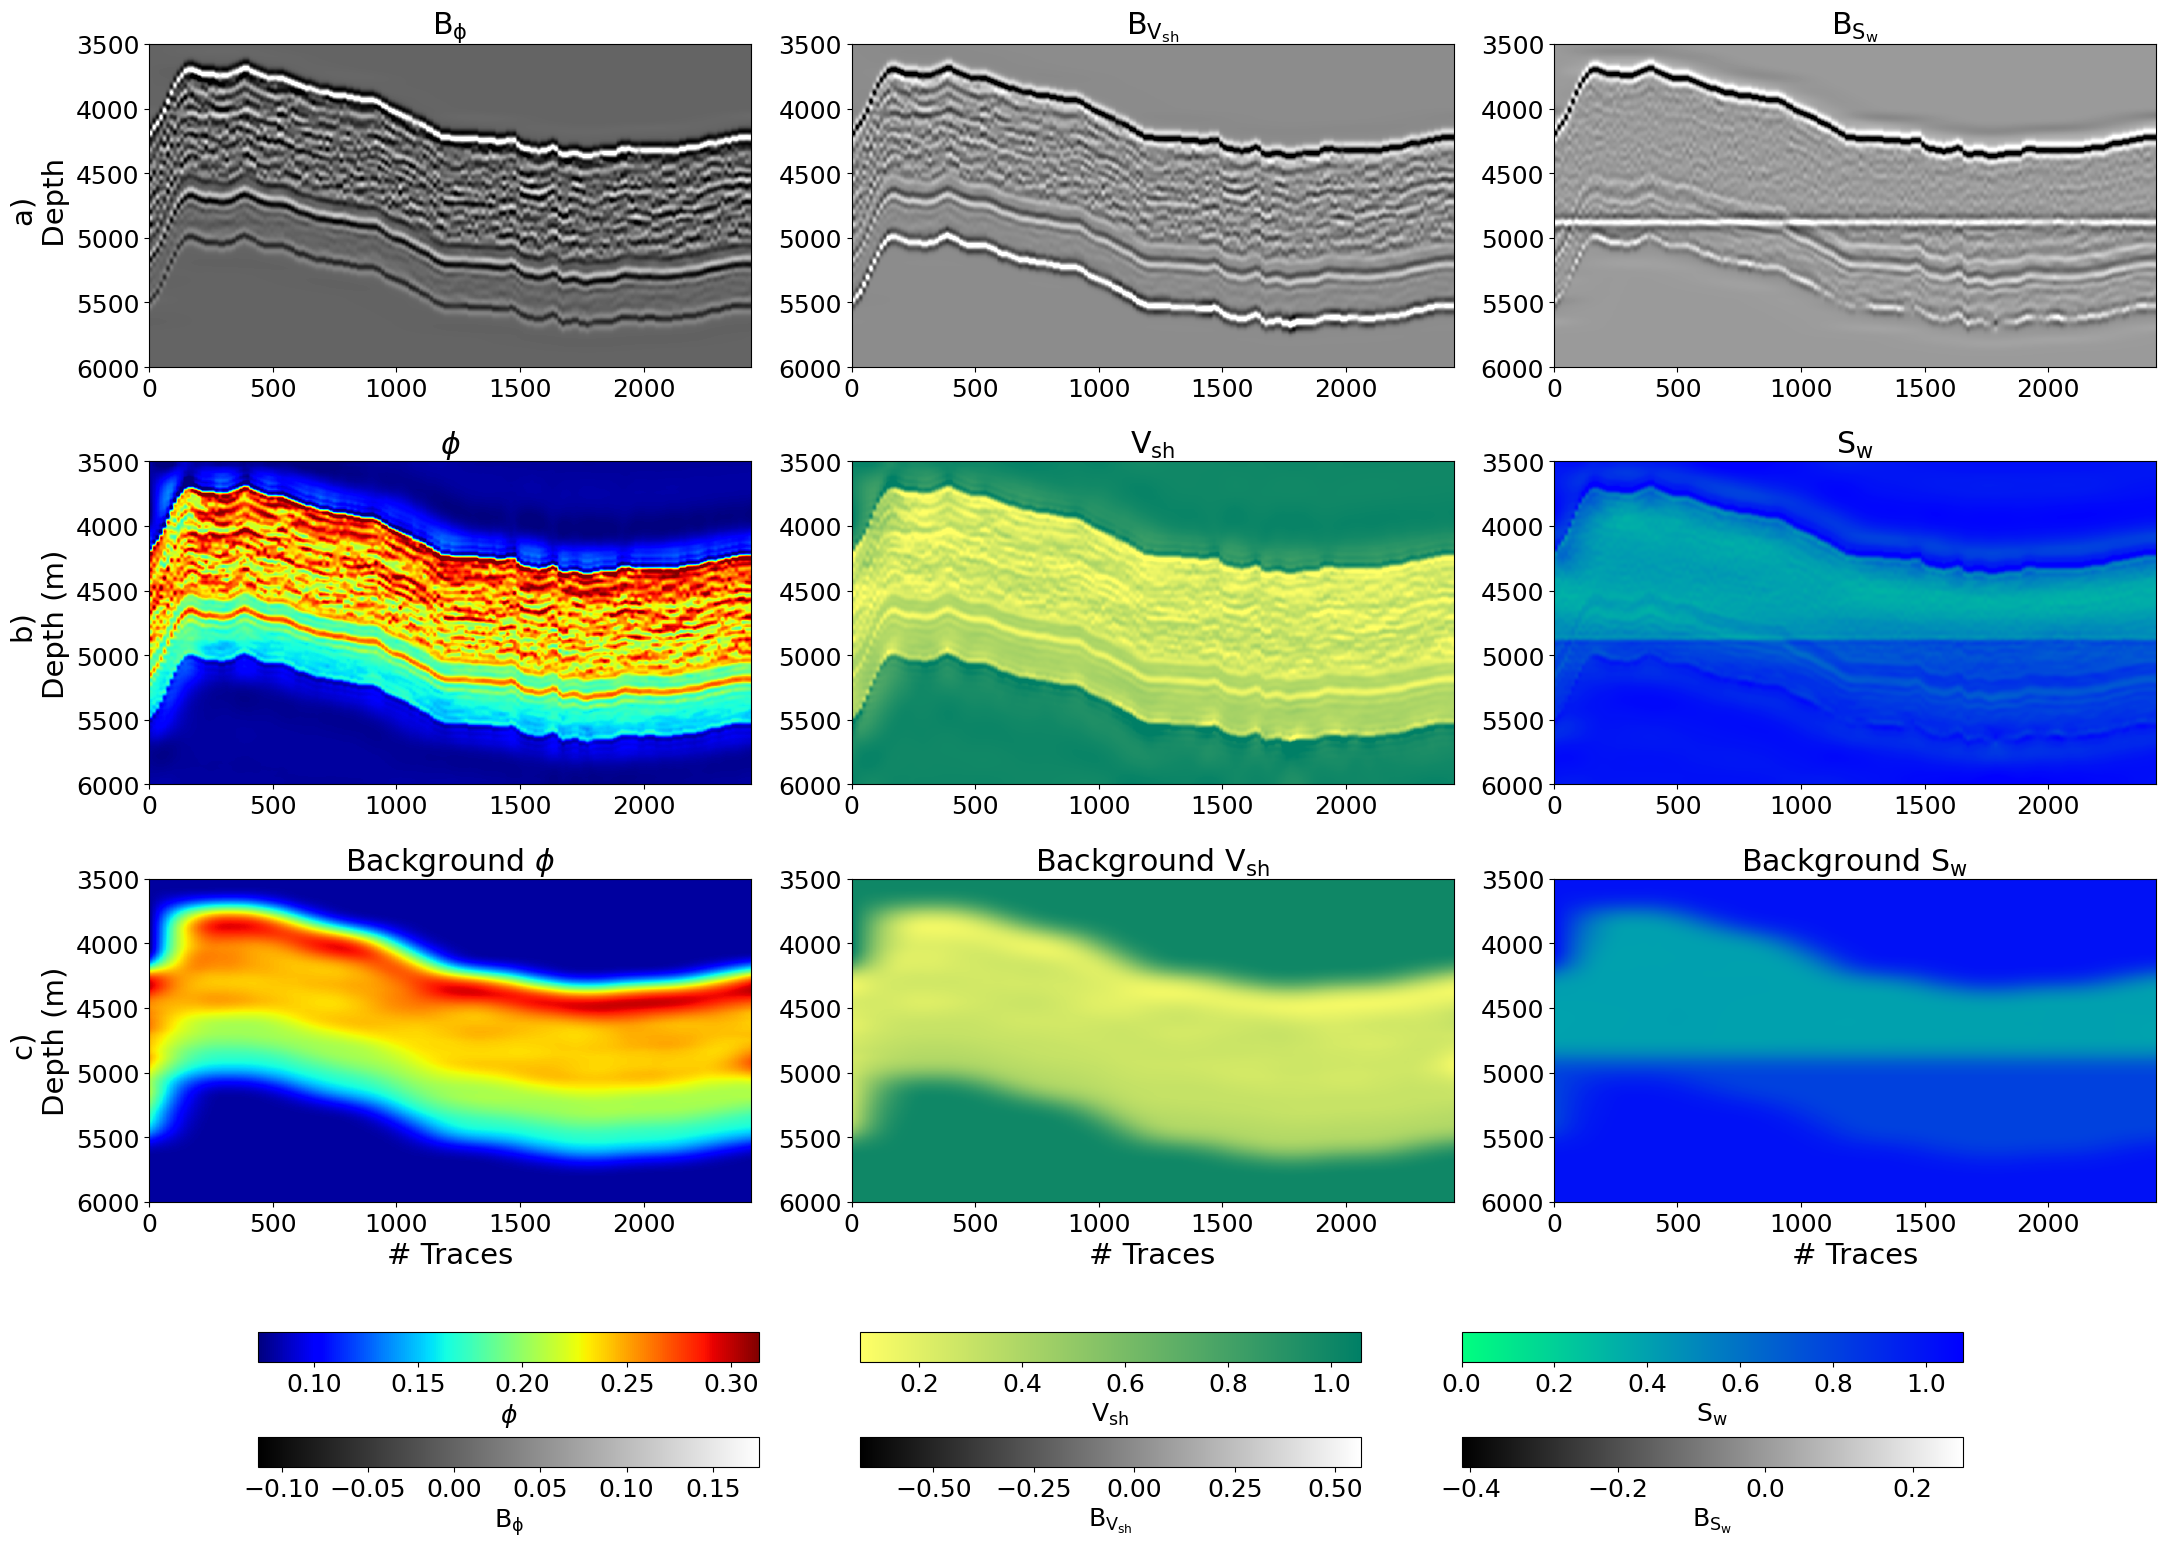

In [34]:
# Select number of p optimal coeffcients 
p = 5
Fp, Lp, Vp, F, L, V, r_zoeppritz, r_zoeppritz_back, d_well = Seis2Rock_training(vp=vp, vs=vs, rho=rho, 
                                                                      wav_est=wav, nt_wav=hcenter, 
                                                                      vp_back=vp_back, vs_back=vs_back, rho_back=rho_back, 
                                                                      p=p, 
                                                                      thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

b_optAVO_1, r_zoeppritz_back, Cp, Hp, Cp_estimated = Seis2Rock_inference(vp=vp_2D_back.T, vs=vs_2D_back.T, rho=rho_2D_back.T, 
                                                         wav_est=wav, nt_wav=hcenter, dtheta=d.transpose(0,2,1), 
                                                         Fp=Fp, Lp=Lp, Vp=Vp, 
                                                         phi=phi, vsh=vsh, sw=sw, 
                                                         phi_back=phi_back, vsh_back=vsh_back, sw_back=sw_back, 
                                                         d=d_well,
                                                         thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)


## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind = 'forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=b_optAVO_1.shape[1], 
                                                  spatdims=b_optAVO_1.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO_1.shape[1],  b_optAVO_1.shape[2]], dtype='float64')



## Hyperparameters for optimization
niter = 50
lamba1 = np.sqrt(1e-2)
damp1 = 10e-2

lamba2 = np.sqrt(1e-1)
damp2 = 1e-2

lamba3=np.sqrt(2e-2)
damp3 = 10e0

## Inverting for porosity
phi_inv_dense_reg_1 = regularized_inversion(D, b_optAVO_1[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(phi_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(phi_2D_back[:,:].shape) 

## Inverting for vsh
vsh_inv_dense_reg_1 = regularized_inversion(D, b_optAVO_1[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=(vsh_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp2))[0].reshape(vsh_2D_back[:,:].shape) 

## Inverting for sw
sw_inv_dense_reg_1 = regularized_inversion(D, b_optAVO_1[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=sw_2D_back[:,:].ravel(),
                                    **dict(iter_lim=50, damp=damp2))[0].reshape(sw_2D_back[:,:].shape) 

# Inversion plot
fig = plot_inversion_results_2D(wellname='x', depth=depth, x_axis=x_axis,
                                   phi_inv_dense_reg=phi_inv_dense_reg_1, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg_1, 
                                   sw_inv_dense_reg=sw_inv_dense_reg_1, 
                                   b_optAVO=b_optAVO_1,
                                   phi_fence_bg=phi_2D_back.T, 
                                   vsh_fence_bg=vsh_2D_back.T, 
                                   sw_fence_bg=sw_2D_back.T,
                                   fontsize=18,
                                   title_on=False)

### Seis2Rock framework stacking 2 wells 

In [35]:
#stacking the Elastic logs 
vp_stack = np.concatenate((vp, vp_2))
vs_stack = np.concatenate((vs, vs_2))
rho_stack = np.concatenate((rho, rho_2))

vp_stack_back= np.concatenate((vp_back, vp_2_back))
vs_stack_back = np.concatenate((vs_back, vs_2_back))
rho_stack_back = np.concatenate((rho_back, rho_2_back))


#stacking the Petrophysical logs 
phi_stack = np.concatenate((phi, phi_2))
vsh_stack = np.concatenate((vsh, vsh_2))
sw_stack = np.concatenate((sw, sw_2))

phi_stack_back = np.concatenate((phi_back, phi_2_back))
vsh_stack_back = np.concatenate((vsh_back, vsh_2_back))
sw_stack_back = np.concatenate((sw_back, sw_2_back))

In [36]:
# Select number of p optimal coeffcients 
p = 5
Fp, Lp, Vp, F, L, V, r_zoeppritz, r_zoeppritz_back, d_well = Seis2Rock_training(vp=vp_stack, vs=vs_stack, rho=rho_stack, 
                                                                      wav_est=wav, nt_wav=hcenter, 
                                                                      vp_back=vp_stack_back, vs_back=vs_stack_back, rho_back=rho_stack_back, 
                                                                      p=p, 
                                                                      thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

Computing AVO synthetic gathers from the well logs...
Performing SVD...
Extracting Optimal basis functions Fp..
Done! xD


In [37]:
# This function works only for one well
b_optAVO_2, r_zoeppritz_back, Cp, Hp, Cp_estimated = Seis2Rock_inference(vp=vp_2D_back.T, vs=vs_2D_back.T, rho=rho_2D_back.T, 
                                                         wav_est=wav, nt_wav=hcenter, dtheta=d.transpose(0,2,1), 
                                                         Fp=Fp, Lp=Lp, Vp=Vp, 
                                                         phi=phi_stack, vsh=vsh_stack, sw=sw_stack, 
                                                         phi_back=phi_stack_back, vsh_back=vsh_stack_back, sw_back=sw_stack_back, 
                                                         d=d_well,
                                                         thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

Computing AVO synthetic gather for background models...
Calculating matrix of optimal coefficients Cp...
Creating the new data term (Petrophysical coefficeints B)...
Done xD !


In [49]:
## Here we should create the boptAVO taking into accoun a block diagonal operator per well 

#First Well
m_full_1 = np.stack((phi, vsh, sw), axis=0)
m_back_1 = np.stack((phi_back, vsh_back, sw_back), axis=0)

#Second Well
m_full_2 = np.stack((phi_2, vsh_2, sw_2), axis=0)
m_back_2 = np.stack((phi_2_back, vsh_2_back, sw_2_back), axis=0)


Logsize_1 = len(phi)
Logsize_2 = len(phi_2)
kind = 'forward'

# PoststackLinearModelling operator
D_1 = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=Logsize_1, spatdims=Logsize_1, explicit=True, kind=kind)
D_A_1 = D_1.A.copy()

D_2 = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=Logsize_2, spatdims=Logsize_2, explicit=True, kind=kind)
D_A_2 = D_2.A.copy()


#Combine full operator for two wells
# Create a block diagonal matrix
D_A = np.block([[D_A_1, np.zeros_like(D_A_2)],
                [np.zeros_like(D_A_1), D_A_2]])

m_full = np.concatenate((m_full_1, m_full_2), axis=1)
m_back = np.concatenate((m_back_1, m_back_2), axis=1)

# Compute b_full_prof and b_back_prof
b_full_prof = D_A @ m_full.T
b_back_prof = D_A @ m_back.T

# Calculate the new data term (Petrophysical coefficients B)
b_optAVO_2 = Cp.transpose(0, 2, 1) @ Hp.T @ (b_full_prof - b_back_prof)
b_optAVO_2 = b_optAVO_2.transpose(2, 1, 0)

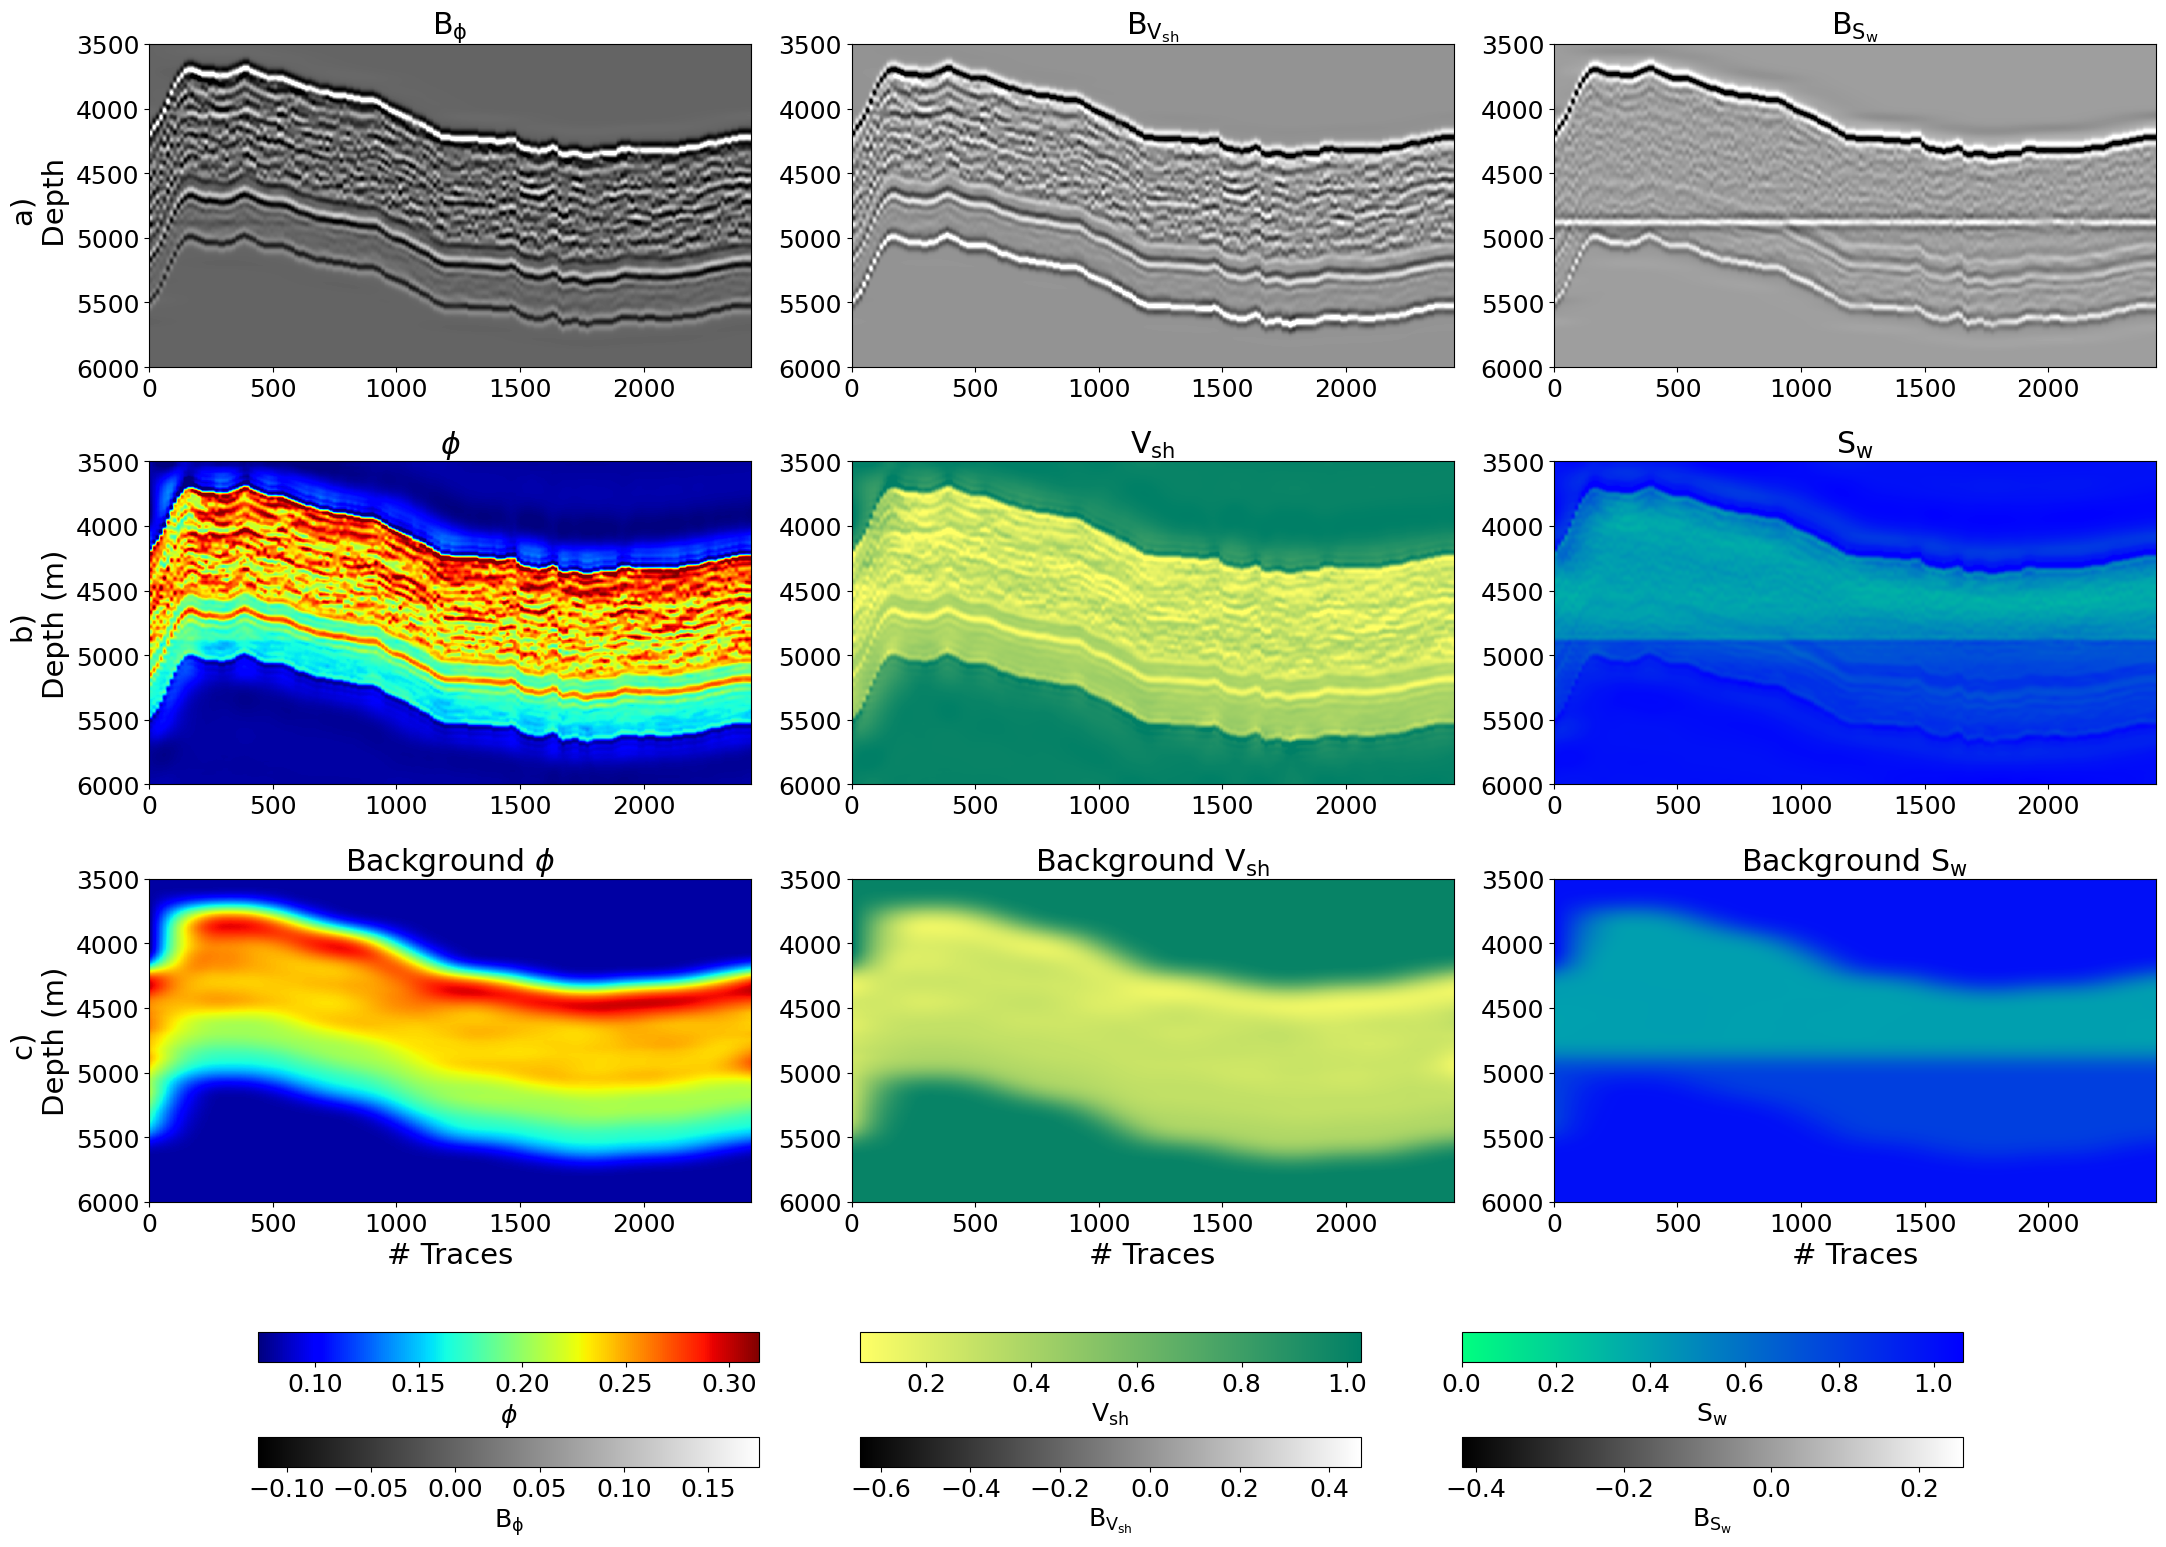

In [50]:
## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind = 'forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=b_optAVO_2.shape[1], 
                                                  spatdims=b_optAVO_2.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO_2.shape[1],  b_optAVO_2.shape[2]], dtype='float64')



## Hyperparameters for optimization
niter = 50
lamba1 = np.sqrt(1e-2)
damp1 = 10e-2

lamba2 = np.sqrt(1e-1)
damp2 = 1e-2

lamba3=np.sqrt(2e-2)
damp3 = 10e0

## Inverting for porosity
phi_inv_dense_reg_2 = regularized_inversion(D, b_optAVO_2[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(phi_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(phi_2D_back[:,:].shape) 

## Inverting for vsh
vsh_inv_dense_reg_2 = regularized_inversion(D, b_optAVO_2[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=(vsh_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp2))[0].reshape(vsh_2D_back[:,:].shape) 

## Inverting for sw
sw_inv_dense_reg_2 = regularized_inversion(D, b_optAVO_2[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=sw_2D_back[:,:].ravel(),
                                    **dict(iter_lim=50, damp=damp2))[0].reshape(sw_2D_back[:,:].shape) 

# Inversion plot
fig = plot_inversion_results_2D(wellname='x', depth=depth, x_axis=x_axis,
                                   phi_inv_dense_reg=phi_inv_dense_reg_2, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg_2, 
                                   sw_inv_dense_reg=sw_inv_dense_reg_2, 
                                   b_optAVO=b_optAVO_2,
                                   phi_fence_bg=phi_2D_back.T, 
                                   vsh_fence_bg=vsh_2D_back.T, 
                                   sw_fence_bg=sw_2D_back.T,
                                   fontsize=18,
                                   title_on=False)

### Seis2Rock framework stacking 3 wells 

In [51]:
#stacking the Elastic logs 
vp_stack = np.concatenate((vp, vp_2, vp_3))
vs_stack = np.concatenate((vs, vs_2, vs_3))
rho_stack = np.concatenate((rho, rho_2, rho_3))

vp_stack_back= np.concatenate((vp_back, vp_2_back, vp_3_back))
vs_stack_back = np.concatenate((vs_back, vs_2_back, vs_3_back))
rho_stack_back = np.concatenate((rho_back, rho_2_back, rho_3_back))


#stacking the Petrophysical logs 
phi_stack = np.concatenate((phi, phi_2, phi_3))
vsh_stack = np.concatenate((vsh, vsh_2, vsh_3))
sw_stack = np.concatenate((sw, sw_2, sw_3))

phi_stack_back = np.concatenate((phi_back, phi_2_back, phi_3_back))
vsh_stack_back = np.concatenate((vsh_back, vsh_2_back, vsh_3_back))
sw_stack_back = np.concatenate((sw_back, sw_2_back, sw_3_back))

In [52]:
# Select number of p optimal coeffcients 
p = 5
Fp, Lp, Vp, F, L, V, r_zoeppritz, r_zoeppritz_back, d_well = Seis2Rock_training(vp=vp_stack, vs=vs_stack, rho=rho_stack, 
                                                                      wav_est=wav, nt_wav=hcenter, 
                                                                      vp_back=vp_stack_back, vs_back=vs_stack_back, rho_back=rho_stack_back, 
                                                                      p=p, 
                                                                      thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

b_optAVO_3, r_zoeppritz_back, Cp, Hp, Cp_estimated = Seis2Rock_inference(vp=vp_2D_back.T, vs=vs_2D_back.T, rho=rho_2D_back.T, 
                                                         wav_est=wav, nt_wav=hcenter, dtheta=d.transpose(0,2,1), 
                                                         Fp=Fp, Lp=Lp, Vp=Vp, 
                                                         phi=phi_stack, vsh=vsh_stack, sw=sw_stack, 
                                                         phi_back=phi_stack_back, vsh_back=vsh_stack_back, sw_back=sw_stack_back, 
                                                         d=d_well,
                                                         thetamin=thetamin, thetamax=thetamax, ntheta=ntheta)

Computing AVO synthetic gathers from the well logs...
Performing SVD...
Extracting Optimal basis functions Fp..
Done! xD
Computing AVO synthetic gather for background models...
Calculating matrix of optimal coefficients Cp...
Creating the new data term (Petrophysical coefficeints B)...
Done xD !


In [53]:
## Here we should create the boptAVO taking into accoun a block diagonal operator per well 

#First Well
m_full_1 = np.stack((phi, vsh, sw), axis=0)
m_back_1 = np.stack((phi_back, vsh_back, sw_back), axis=0)

#Second Well
m_full_2 = np.stack((phi_2, vsh_2, sw_2), axis=0)
m_back_2 = np.stack((phi_2_back, vsh_2_back, sw_2_back), axis=0)

#Third Well
m_full_3 = np.stack((phi_3, vsh_3, sw_3), axis=0)
m_back_3 = np.stack((phi_3_back, vsh_3_back, sw_3_back), axis=0)


Logsize_1 = len(phi)
Logsize_2 = len(phi_2)
Logsize_3 = len(phi_3)

kind = 'forward'

# PoststackLinearModelling operator
D_1 = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=Logsize_1, spatdims=Logsize_1, explicit=True, kind=kind)
D_A_1 = D_1.A.copy()

D_2 = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=Logsize_2, spatdims=Logsize_2, explicit=True, kind=kind)
D_A_2 = D_2.A.copy()

D_3 = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=Logsize_3, spatdims=Logsize_3, explicit=True, kind=kind)
D_A_3 = D_3.A.copy()


#Combine full operator for two wells
# Create a block diagonal matrix
D_A = combined_matrix = np.block([[D_A_1, np.zeros_like(D_A_2), np.zeros_like(D_A_3)],
                                  [np.zeros_like(D_A_1), D_A_2, np.zeros_like(D_A_3)],
                                  [np.zeros_like(D_A_1), np.zeros_like(D_A_2), D_A_3]
])

m_full = np.concatenate((m_full_1, m_full_2, m_full_3), axis=1)
m_back = np.concatenate((m_back_1, m_back_2, m_back_3), axis=1)

# Compute b_full_prof and b_back_prof
b_full_prof = D_A @ m_full.T
b_back_prof = D_A @ m_back.T

# Calculate the new data term (Petrophysical coefficients B)
b_optAVO_3 = Cp.transpose(0, 2, 1) @ Hp.T @ (b_full_prof - b_back_prof)
b_optAVO_3 = b_optAVO_3.transpose(2, 1, 0)

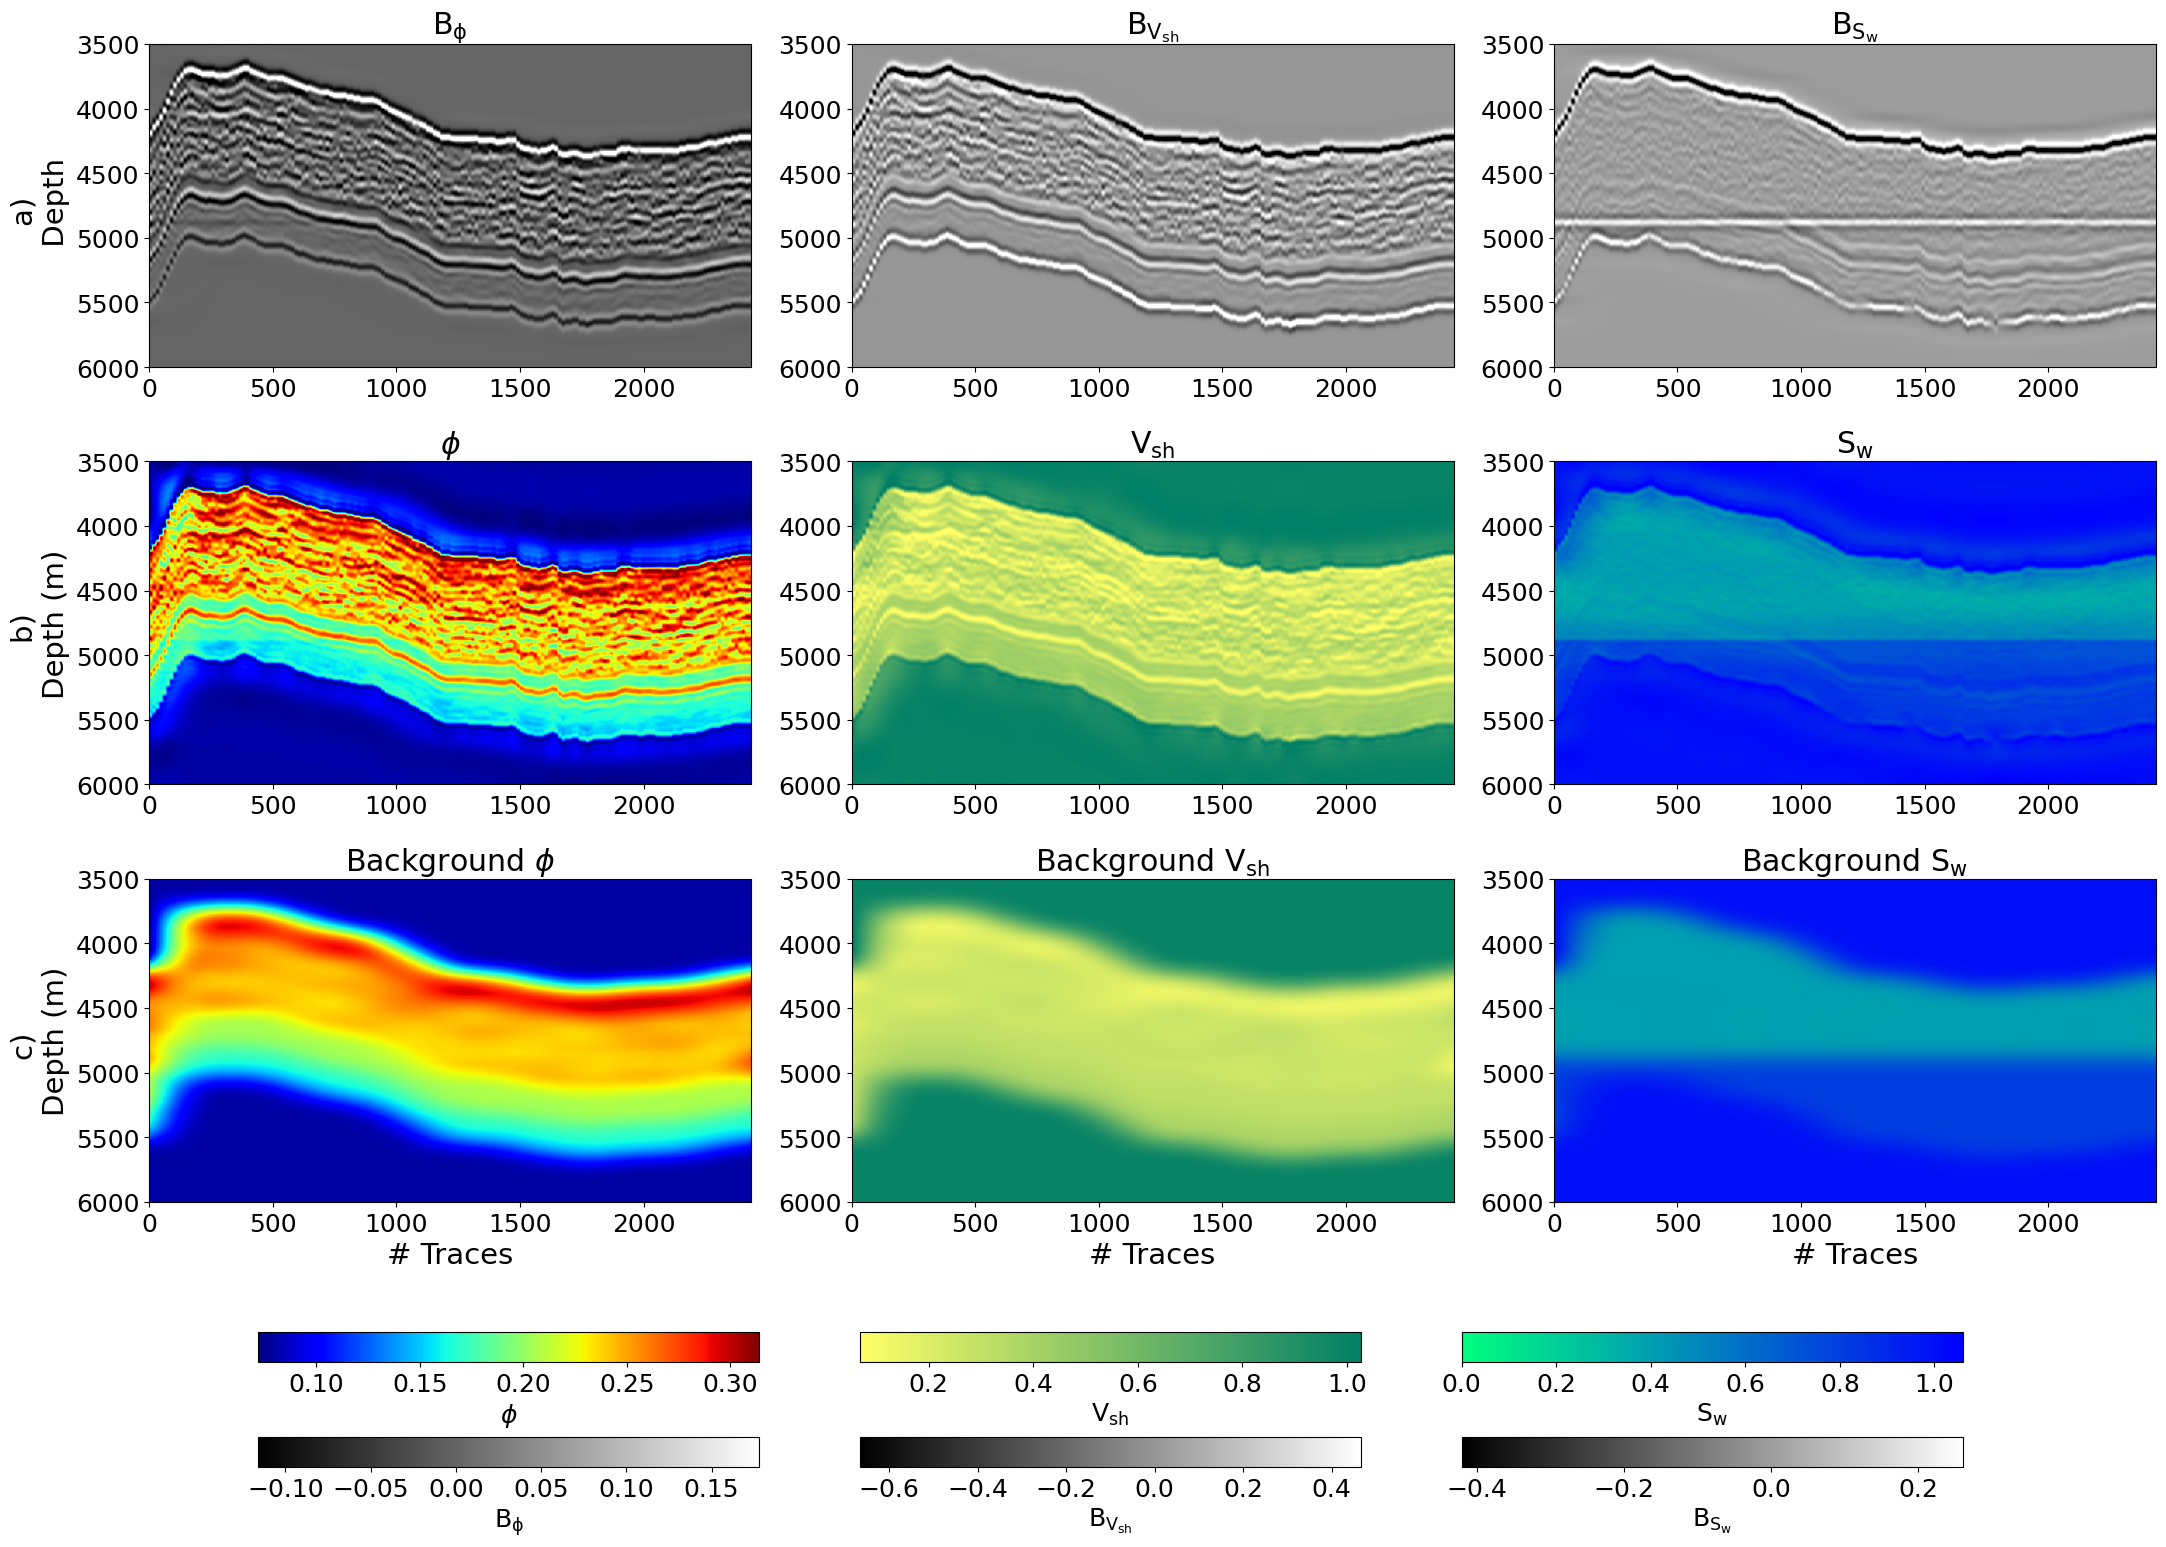

In [54]:
## Series of poststack seismic inversion (one per parameter)
## Here we use B as our 'new data term' which is the petrophysical coefficients

## Creating Post Stack Operator
kind = 'forward'
D = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=b_optAVO_3.shape[1], 
                                                  spatdims=b_optAVO_3.shape[2],explicit=True, kind=kind)

## Creating Regularization (In this case Laplacian Regularization)
D2op  = Laplacian([b_optAVO_3.shape[1],  b_optAVO_3.shape[2]], dtype='float64')



## Hyperparameters for optimization
niter = 50
lamba1 = np.sqrt(1e-2)
damp1 = 10e-2

lamba2 = np.sqrt(1e-1)
damp2 = 1e-2

lamba3=np.sqrt(2e-2)
damp3 = 10e0

## Inverting for porosity
phi_inv_dense_reg_3 = regularized_inversion(D, b_optAVO_3[0].ravel(), Regs=[D2op],
                                    epsRs=[lamba1],x0=(phi_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp1))[0].reshape(phi_2D_back[:,:].shape) 

## Inverting for vsh
vsh_inv_dense_reg_3 = regularized_inversion(D, b_optAVO_3[1].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=(vsh_2D_back[:,:].ravel()),
                                    **dict(iter_lim=niter, damp=damp2))[0].reshape(vsh_2D_back[:,:].shape) 

## Inverting for sw
sw_inv_dense_reg_3 = regularized_inversion(D, b_optAVO_3[2].ravel(), Regs=[D2op],
                                    epsRs=[lamba2],x0=sw_2D_back[:,:].ravel(),
                                    **dict(iter_lim=50, damp=damp2))[0].reshape(sw_2D_back[:,:].shape) 

# Inversion plot
fig = plot_inversion_results_2D(wellname='x', depth=depth, x_axis=x_axis,
                                   phi_inv_dense_reg=phi_inv_dense_reg_3, 
                                   vsh_inv_dense_reg=vsh_inv_dense_reg_3, 
                                   sw_inv_dense_reg=sw_inv_dense_reg_3, 
                                   b_optAVO=b_optAVO_3,
                                   phi_fence_bg=phi_2D_back.T, 
                                   vsh_fence_bg=vsh_2D_back.T, 
                                   sw_fence_bg=sw_2D_back.T,
                                   fontsize=18,
                                   title_on=False)

### Comparing Results

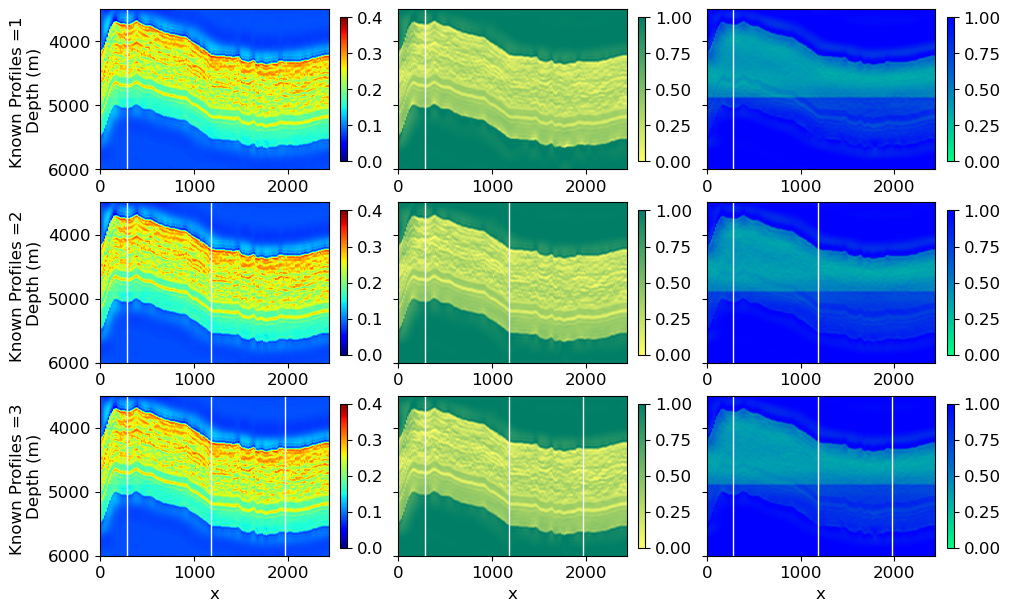

In [19]:
fig = plot_comparison_training_stacking(depth=depth, x_axis=x_axis, x_locs = [x_loc1, x_loc2, x_loc3], 
                               phi_inv_dense_regs = [phi_inv_dense_reg_1, phi_inv_dense_reg_2, phi_inv_dense_reg_3], 
                               vsh_inv_dense_regs = [vsh_inv_dense_reg_1, vsh_inv_dense_reg_2, vsh_inv_dense_reg_3], 
                               sw_inv_dense_regs = [sw_inv_dense_reg_1, sw_inv_dense_reg_2, sw_inv_dense_reg_3], fontsize=12)

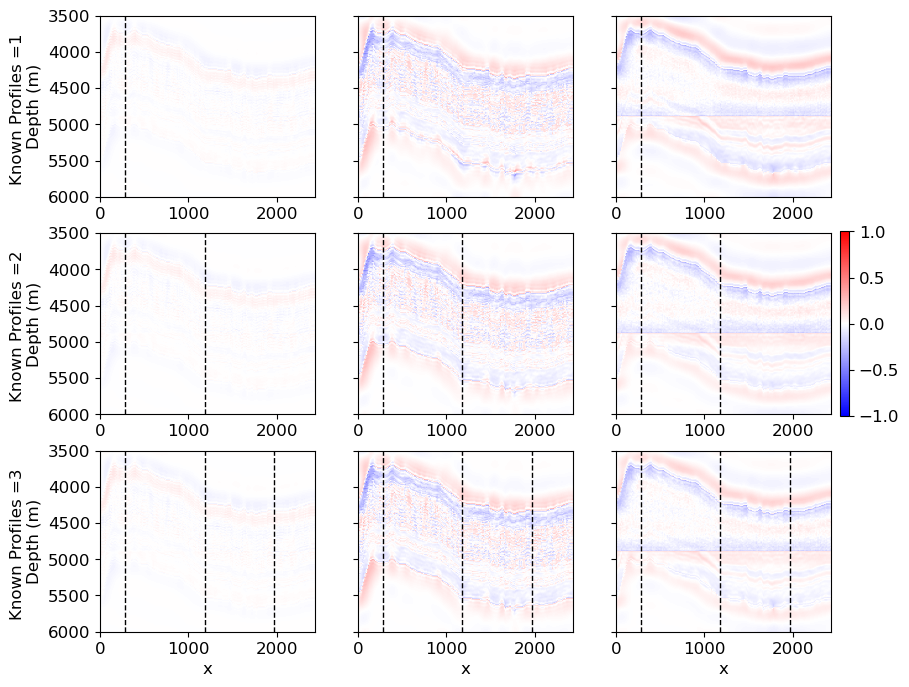

In [55]:
fig = plot_comparison_error_stacking(depth=depth, x_axis=x_axis, x_locs = [x_loc1, x_loc2, x_loc3], 
                               phi_inv_dense_regs = [phi_2D-phi_inv_dense_reg_1, phi_2D-phi_inv_dense_reg_2, phi_2D-phi_inv_dense_reg_3], 
                               vsh_inv_dense_regs = [vsh_2D-vsh_inv_dense_reg_1, vsh_2D-vsh_inv_dense_reg_2, vsh_2D-vsh_inv_dense_reg_3], 
                               sw_inv_dense_regs = [sw_2D-sw_inv_dense_reg_1, sw_2D-sw_inv_dense_reg_2, sw_2D-sw_inv_dense_reg_3], fontsize=12)